In [1]:
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.checkpoint.postgres import PostgresSaver
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

c:\Codes\Learning\Lang_graph\venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
load_dotenv()

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [3]:

res = llm.invoke("hi").content

In [4]:
res

'Hi there! How can I help you today?'

In [5]:

def chat(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


In [12]:
from langchain.messages import RemoveMessage
from langgraph.checkpoint.memory import InMemorySaver


In [7]:
def delete_old_messages(state: MessagesState):
    msgs = state["messages"]

    # if more than 10 messages, delete the earliest 6
    if len(msgs) > 10:
        to_remove = msgs[:6]
        return {"messages": [RemoveMessage(id=m.id) for m in to_remove]}

    return {}

In [8]:
builder = StateGraph(MessagesState)
builder.add_node("chat", chat)
builder.add_node("cleanup", delete_old_messages)


In [9]:
builder.add_edge(START, "chat")
builder.add_edge("chat", "cleanup")   # run deletion after each response
builder.add_edge("cleanup", "__end__")

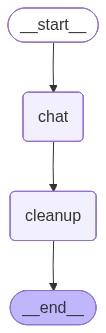

In [13]:

graph = builder.compile(checkpointer=InMemorySaver())
graph

In [14]:
config = {"configurable": {"thread_id": "t1"}}

In [15]:
graph.invoke({"messages": [{"role": "user", "content": "Hi, I'm Abhinav"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Tell me about LangGraph"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Now explain checkpointers"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Langchain"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Quantum Mechanics"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Gen AI"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is my name"}]}, config)

{'messages': [HumanMessage(content='What is Langchain', additional_kwargs={}, response_metadata={}, id='3ee5253c-7509-4616-b996-6de99ff70c2f'),
  AIMessage(content='Okay, Abhinav, let\'s zoom out a bit. If LangGraph is like a sophisticated orchestrator for complex AI workflows, then **LangChain** is the broader framework that provides all the instruments and sheet music needed to build those workflows in the first place.\n\n**LangChain is an open-source framework designed to simplify the development of applications powered by large language models (LLMs).**\n\nIts core idea is to make it easy to **connect LLMs with external data sources and computational tools**, enabling LLMs to go beyond just generating text based on their training data.\n\n### The Core Problem LangChain Solves\n\nBefore LangChain, building anything beyond a simple prompt-response LLM application was quite challenging. You\'d have to:\n\n*   Manually handle API calls to different LLMs (OpenAI, Hugging Face, etc.).\n*

In [16]:
snap = graph.get_state(config)
print("Stored messages after cleanup:", len(snap.values["messages"]))

Stored messages after cleanup: 8
